In [1]:
import pandas as pd

data_path= "shouru.xlsx"
raw_data=pd.read_excel(data_path)
## 选取需要使用的列
cols=["workclass", "sex", "age", "education_num",
        "capital_gain", "capital_loss", "hours_per_week", "label"]
data = raw_data[cols]

In [2]:
# 将label转换为可以运算的变量
data.loc[:, "label_code"] = pd.Categorical(data.label).codes
data.head()

C:\Users\yyx\AppData\Local\Temp\ipykernel_16144\1637673072.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "label_code"] = pd.Categorical(data.label).codes


,workclass,sex,age,education_num,capital_gain,capital_loss,hours_per_week,label,label_code
0,State-gov,Male,39,13,2174,0,40,<=50K,0
1,Self-emp-not-inc,Male,50,13,0,0,13,<=50K,0
2,Private,Male,38,9,0,0,40,<=50K,0
3,Private,Male,53,7,0,0,40,<=50K,0
4,Private,Female,28,13,0,0,40,<=50K,0


In [3]:
# 打印列表中的唯一值
print(data["sex"].unique())
print(data["workclass"].unique())

[' Male' ' Female']
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']


显示sex, label交叉报表：
sex     label
Female  <=50K     9592
        >50K      1179
Male    <=50K    15128
        >50K      6662
dtype: int64


(<Figure size 640x480 with 1 Axes>,
 {(' Female', ' >50K'): (0.0,
   np.float64(0.0),
   0.3291487649434411,
   np.float64(0.10909693217699427)),
  (' Female', ' <=50K'): (0.0,
   np.float64(0.11241919131320689),
   0.3291487649434411,
   np.float64(0.887580808686793)),
  (' Male', ' >50K'): (0.3341238893215505,
   np.float64(0.0),
   0.6658761106784495,
   np.float64(0.3047208402769413)),
  (' Male', ' <=50K'): (0.3341238893215505,
   np.float64(0.30804309941315394),
   0.6658761106784495,
   np.float64(0.691956900586846))})

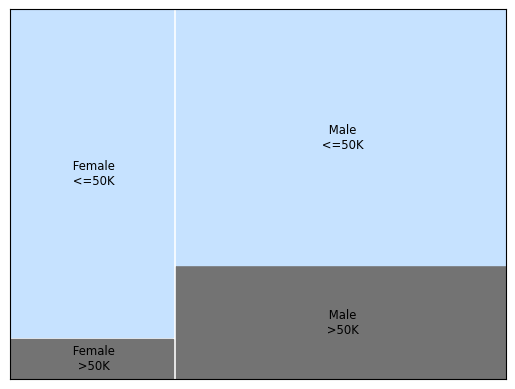

In [4]:
# 利用交叉报表，直观了解数据
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic


# 计算sex, label交叉报表
cross1 = pd.crosstab(data["sex"], data["label"]) #作用是构建一个交叉表，用于统计两个（或多个）分类变量之间的频数关系
print("显示sex, label交叉报表：")
print(cross1.stack())
# 将交叉报表图形化
props = lambda key: {"color": "0.45"} if ' >50K' in key else {"color": "#C6E2FF"}
mosaic(cross1[[" >50K", " <=50K"]].stack(), properties=props, axes_label=False)

In [5]:
# 将数据分为训练集和测试集
from sklearn.model_selection import train_test_split


train_set, test_set = train_test_split(data, test_size=0.2, random_state=2111)

In [6]:
# 训练模型
import statsmodels.api as sm


c_formula = "label_code ~ C(sex) + C(workclass) + education_num + capital_gain + capital_loss + hours_per_week"
c_model = sm.Logit.from_formula(c_formula, data=train_set)
c_model = c_model.fit()

         Current function value: 0.405259
         Iterations: 35


D:\conda\envs\timing_algorithm\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
# 展示模型结果
print(c_model.summary())

                           Logit Regression Results                           
Dep. Variable:             label_code   No. Observations:                26048
Model:                          Logit   Df Residuals:                    26034
Method:                           MLE   Df Model:                           13
Date:                Thu, 03 Jul 2025   Pseudo R-squ.:                  0.2648
Time:                        11:22:09   Log-Likelihood:                -10556.
converged:                      False   LL-Null:                       -14359.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -7.6282      0.145    -52.505      0.000      -7.913      -7.343
C(sex)[T. Male]                       1.2558      0.045     27

In [8]:
# 去掉不显著的虚拟变量
import numpy as np


# 定义workclass的类别顺序，数组里的第一个值为基准类别
l = [" ?", " Never-worked", " Without-pay", " State-gov",
     " Self-emp-not-inc", " Private", " Federal-gov",
     " Local-gov",  " Self-emp-inc"]
# 定义各个类别对应的虚拟变量
contrast = np.eye(9, 6, k=-3)
contrast

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [9]:
# 为每个虚拟变量命名
from patsy import ContrastMatrix


contrast_mat = ContrastMatrix(contrast, l[3:])
contrast_mat

ContrastMatrix(array([[0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0.],
                      [1., 0., 0., 0., 0., 0.],
                      [0., 1., 0., 0., 0., 0.],
                      [0., 0., 1., 0., 0., 0.],
                      [0., 0., 0., 1., 0., 0.],
                      [0., 0., 0., 0., 1., 0.],
                      [0., 0., 0., 0., 0., 1.]]),
               [' State-gov',
                ' Self-emp-not-inc',
                ' Private',
                ' Federal-gov',
                ' Local-gov',
                ' Self-emp-inc'])

In [10]:
# 将不显著的虚拟变量剔除，搭建模型
m_formula = """label_code ~ C(workclass, contrast_mat, levels=l)
        + C(sex) + education_num + capital_gain
        + capital_loss + hours_per_week"""
m_model = sm.Logit.from_formula(m_formula, data=train_set)
m_model = m_model.fit()

Optimization terminated successfully.
         Current function value: 0.405321
         Iterations 8


In [11]:
# 展示模型结果
print(m_model.summary())

                           Logit Regression Results                           
Dep. Variable:             label_code   No. Observations:                26048
Model:                          Logit   Df Residuals:                    26036
Method:                           MLE   Df Model:                           11
Date:                Thu, 03 Jul 2025   Pseudo R-squ.:                  0.2647
Time:                        11:34:49   Log-Likelihood:                -10558.
converged:                       True   LL-Null:                       -14359.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                -7.6422      0.145    -52.624      0.000      -7.927      -7.358
C(

In [12]:
# 搭建不使用类别变量的模型
b_formula = """label_code ~ education_num + capital_gain
        + capital_loss + hours_per_week"""
b_model = sm.Logit.from_formula(b_formula, data=train_set)
b_model = b_model.fit()

Optimization terminated successfully.
         Current function value: 0.426517
         Iterations 8


In [13]:
# 得到预测结果
test_set.loc[:, "b_prob"] = b_model.predict(test_set)
test_set.loc[:, "m_prob"] = m_model.predict(test_set)
test_set.head()

,workclass,sex,age,education_num,capital_gain,capital_loss,hours_per_week,label,label_code,b_prob,m_prob
1704,?,Female,22,10,0,0,35,<=50K,0,0.127790,0.034448
1376,Self-emp-not-inc,Male,44,9,0,0,55,<=50K,0,0.188333,0.196298
14634,Private,Female,39,10,0,0,40,<=50K,0,0.151123,0.064593
21554,Private,Female,29,13,0,0,45,>50K,1,0.360671,0.176411
20959,Private,Female,43,9,0,0,44,<=50K,0,0.131304,0.052917


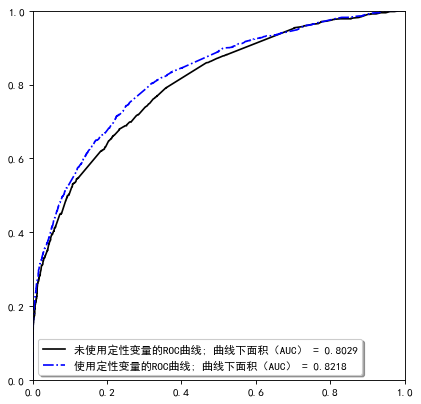

In [16]:
# ROC曲线
from sklearn import metrics

# 设置中文字体
plt.rcParams["font.family"] = ["SimHei"]
# 计算b_model的预测效果
b_fpr, b_tpr, _ = metrics.roc_curve(test_set["label_code"], test_set["b_prob"])
b_auc = metrics.auc(b_fpr, b_tpr)
# 计算m_model的预测效果
m_fpr, m_tpr, _ = metrics.roc_curve(test_set["label_code"], test_set["m_prob"])
m_auc = metrics.auc(m_fpr, m_tpr)
# 画图
fig = plt.figure(figsize=(6, 6), dpi=80)
# 在图形框里只画一幅图
ax = fig.add_subplot(1, 1, 1)
ax.plot(b_fpr, b_tpr, "k",
        label="%s; %s = %0.4f" % ("未使用定性变量的ROC曲线", "曲线下面积（AUC）", b_auc))
ax.plot(m_fpr, m_tpr, "b-.",
        label="%s; %s = %0.4f" % ("使用定性变量的ROC曲线", "曲线下面积（AUC）", m_auc))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
legend = plt.legend(shadow=True)
plt.show()